Phân tích và Đánh giá Chi tiết Dataset với YOLO Model

Mục tiêu:
- Phân tích chi tiết cấu trúc và thuộc tính của dataset
- Huấn luyện mô hình YOLO để phân loại ảnh
- Đánh giá hiệu suất mô hình trên tập test
- Trực quan hóa kết quả và đưa ra khuyến nghị cải thiện

Danh mục dataset:
appliances, bathroom, bedding, cleaning, decor, electronics, furniture, kitchenware, learning, outdoor, personal


1. Cài đặt Môi trường và Thư viện

Cài đặt các thư viện cần thiết cho việc phân tích dataset và huấn luyện YOLO model


In [ ]:
# Cài đặt thư viện Ultralytics YOLO để huấn luyện và sử dụng YOLO model
%pip install ultralytics

# Cài đặt các thư viện cần thiết khác cho xử lý ảnh và machine learning
%pip install opencv-python matplotlib seaborn pandas pillow scikit-learn

print("Installation completed successfully!")


In [1]:
# Import các thư viện cơ bản cho xử lý file, ảnh và visualization
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from pathlib import Path
import shutil
from collections import Counter
import yaml

# Import thư viện YOLO từ Ultralytics
from ultralytics import YOLO

# Import các thư viện sklearn để đánh giá hiệu suất mô hình
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

# Thiết lập style cho các biểu đồ matplotlib
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

print("All libraries imported successfully!")


All libraries imported successfully!


2. Phân tích Chi tiết Dataset

Phân tích số lượng ảnh, cấu trúc thư mục và các thuộc tính của dataset


In [2]:
# Đường dẫn đến thư mục chứa dataset gốc
DATASET_DIR = "dataset"

# Kiểm tra xem thư mục dataset có tồn tại không
if not os.path.exists(DATASET_DIR):
    print(f"Error: Directory '{DATASET_DIR}' not found!")
else:
    print(f"Found dataset directory: {DATASET_DIR}")


Found dataset directory: dataset


In [3]:
# Lấy danh sách các thư mục con (mỗi thư mục là một category/lớp)
categories = sorted([d for d in os.listdir(DATASET_DIR) 
                     if os.path.isdir(os.path.join(DATASET_DIR, d))])

print(f"Found {len(categories)} categories:")
for idx, cat in enumerate(categories, 1):
    print(f"  {idx}. {cat}")


Found 11 categories:
  1. appliances
  2. bathroom
  3. bedding
  4. cleaning
  5. decor
  6. electronics
  7. furniture
  8. kitchenware
  9. learning
  10. outdoor
  11. personal


In [4]:
# Hàm đếm số lượng ảnh trong thư mục (bao gồm cả thư mục con)
def count_images_recursive(folder_path):
    """
    Đếm tổng số file ảnh trong thư mục và tất cả thư mục con.
    
    Args:
        folder_path: Đường dẫn đến thư mục cần đếm
        
    Returns:
        count: Tổng số file ảnh
        image_paths: Danh sách đường dẫn đến tất cả file ảnh
    """
    # Các định dạng file ảnh được hỗ trợ
    image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.gif', '.webp', '.avif'}
    count = 0
    image_paths = []
    
    # Duyệt qua tất cả file trong thư mục và thư mục con
    for root, _, files in os.walk(folder_path):
        for file in files:
            if Path(file).suffix.lower() in image_extensions:
                count += 1
                image_paths.append(os.path.join(root, file))
    
    return count, image_paths

# Phân tích số lượng ảnh trong từng category
category_stats = []

for category in categories:
    category_path = os.path.join(DATASET_DIR, category)
    img_count, img_paths = count_images_recursive(category_path)
    category_stats.append({
        'Category': category,
        'Image Count': img_count,
        'Paths': img_paths
    })

# Tạo DataFrame để hiển thị thống kê dễ đọc hơn
df_stats = pd.DataFrame(category_stats)
df_stats_display = df_stats[['Category', 'Image Count']].copy()

# Hiển thị bảng thống kê
print("\n" + "="*50)
print("DATASET STATISTICS")
print("="*50)
print(df_stats_display.to_string(index=False))
print("="*50)
print(f"Total Images: {df_stats_display['Image Count'].sum()}")
print(f"Average per Category: {df_stats_display['Image Count'].mean():.2f}")
print(f"Min: {df_stats_display['Image Count'].min()}")
print(f"Max: {df_stats_display['Image Count'].max()}")



DATASET STATISTICS
   Category  Image Count
 appliances          133
   bathroom           30
    bedding            6
   cleaning           21
      decor            9
electronics           70
  furniture           18
kitchenware          105
   learning           93
    outdoor            6
   personal          122
Total Images: 613
Average per Category: 55.73
Min: 6
Max: 133


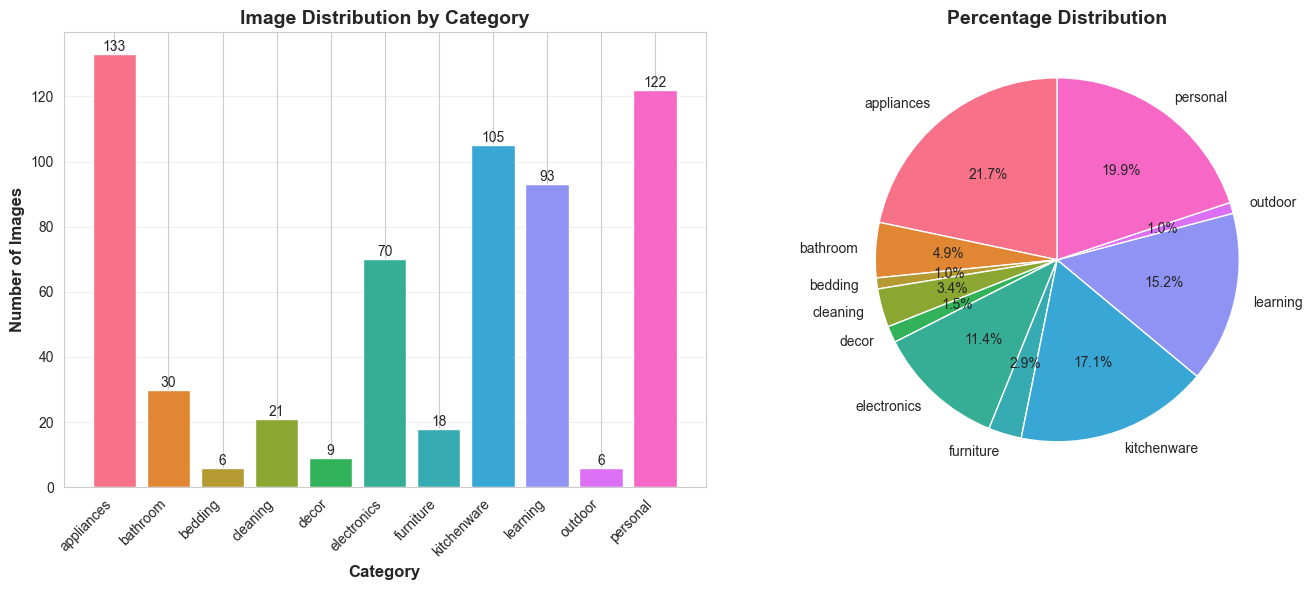


DATASET BALANCE ANALYSIS:
  Imbalance Ratio: 22.17x
  Suggestion: Consider data augmentation or resampling


In [5]:
# Vẽ biểu đồ phân bố số lượng ảnh theo category
plt.figure(figsize=(14, 6))

# Biểu đồ cột
plt.subplot(1, 2, 1)
colors = sns.color_palette("husl", len(categories))
bars = plt.bar(df_stats_display['Category'], df_stats_display['Image Count'], color=colors)
plt.xlabel('Category', fontsize=12, fontweight='bold')
plt.ylabel('Number of Images', fontsize=12, fontweight='bold')
plt.title('Image Distribution by Category', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Thêm giá trị lên đầu mỗi cột
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom', fontsize=10)

# Biểu đồ tròn
plt.subplot(1, 2, 2)
plt.pie(df_stats_display['Image Count'], labels=df_stats_display['Category'],
        autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Percentage Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Phân tích sự cân bằng của dataset
max_count = df_stats_display['Image Count'].max()
min_count = df_stats_display['Image Count'].min()
imbalance_ratio = max_count / min_count if min_count > 0 else float('inf')

print("\nDATASET BALANCE ANALYSIS:")
print(f"  Imbalance Ratio: {imbalance_ratio:.2f}x")
if imbalance_ratio > 5:
    print("  Warning: Dataset is highly imbalanced!")
    print("  Suggestion: Consider data augmentation or resampling")
elif imbalance_ratio > 2:
    print("  Dataset is moderately imbalanced")
    print("  Suggestion: Monitor class-specific performance carefully")
else:
    print("  Dataset is relatively balanced")


In [6]:
# Hàm phân tích thuộc tính của ảnh (kích thước, định dạng, aspect ratio)
def analyze_image_properties(image_paths, sample_size=100):
    """
    Phân tích các thuộc tính cơ bản của ảnh.
    
    Args:
        image_paths: Danh sách đường dẫn đến các file ảnh
        sample_size: Số lượng ảnh mẫu để phân tích (mặc định 100)
        
    Returns:
        widths: Danh sách chiều rộng
        heights: Danh sách chiều cao
        formats: Danh sách định dạng file
        aspect_ratios: Danh sách tỷ lệ khung hình
    """
    widths = []
    heights = []
    formats = []
    aspect_ratios = []
    
    # Lấy mẫu ngẫu nhiên nếu có quá nhiều ảnh để tăng tốc độ xử lý
    if len(image_paths) > sample_size:
        import random
        image_paths = random.sample(image_paths, sample_size)
    
    # Duyệt qua từng ảnh và thu thập thông tin
    for img_path in image_paths:
        try:
            with Image.open(img_path) as img:
                width, height = img.size
                widths.append(width)
                heights.append(height)
                formats.append(img.format)
                aspect_ratios.append(width / height if height > 0 else 0)
        except Exception as e:
            print(f"Error reading {img_path}: {e}")
            continue
    
    return widths, heights, formats, aspect_ratios

# Thu thập tất cả đường dẫn ảnh từ dataset
all_image_paths = []
for stat in category_stats:
    all_image_paths.extend(stat['Paths'])

print(f"Analyzing {len(all_image_paths)} images...")
widths, heights, formats, aspect_ratios = analyze_image_properties(all_image_paths, sample_size=100)

# Kiểm tra xem có ảnh nào được phân tích thành công không
if not widths or not heights:
    print("\n" + "="*50)
    print("ERROR: No images could be analyzed!")
    print("Please check if image files exist and are valid.")
    print("="*50)
else:
    # Hiển thị thống kê kích thước ảnh
    print("\n" + "="*50)
    print("IMAGE SIZE STATISTICS")
    print("="*50)
    print(f"Analyzed: {len(widths)} images")
    print(f"Width - Min: {min(widths)}px, Max: {max(widths)}px, Avg: {np.mean(widths):.0f}px")
    print(f"Height - Min: {min(heights)}px, Max: {max(heights)}px, Avg: {np.mean(heights):.0f}px")
    print(f"\nMost common aspect ratios:")
    ar_counter = Counter([round(ar, 2) for ar in aspect_ratios])
    for ar, count in ar_counter.most_common(3):
        print(f"  {ar:.2f} : {count} images")
    
    # Hiển thị thống kê định dạng file
    print(f"\nFile Formats:")
    format_counter = Counter(formats)
    for fmt, count in format_counter.most_common():
        print(f"  {fmt}: {count} images")


Analyzing 613 images...

IMAGE SIZE STATISTICS
Analyzed: 100 images
Width - Min: 138px, Max: 3000px, Avg: 875px
Height - Min: 134px, Max: 3755px, Avg: 992px

Most common aspect ratios:
  0.75 : 41 images
  1.33 : 15 images
  1.00 : 11 images

File Formats:
  JPEG: 85 images
  PNG: 10 images
  WEBP: 5 images


Detailed Image Size Analysis


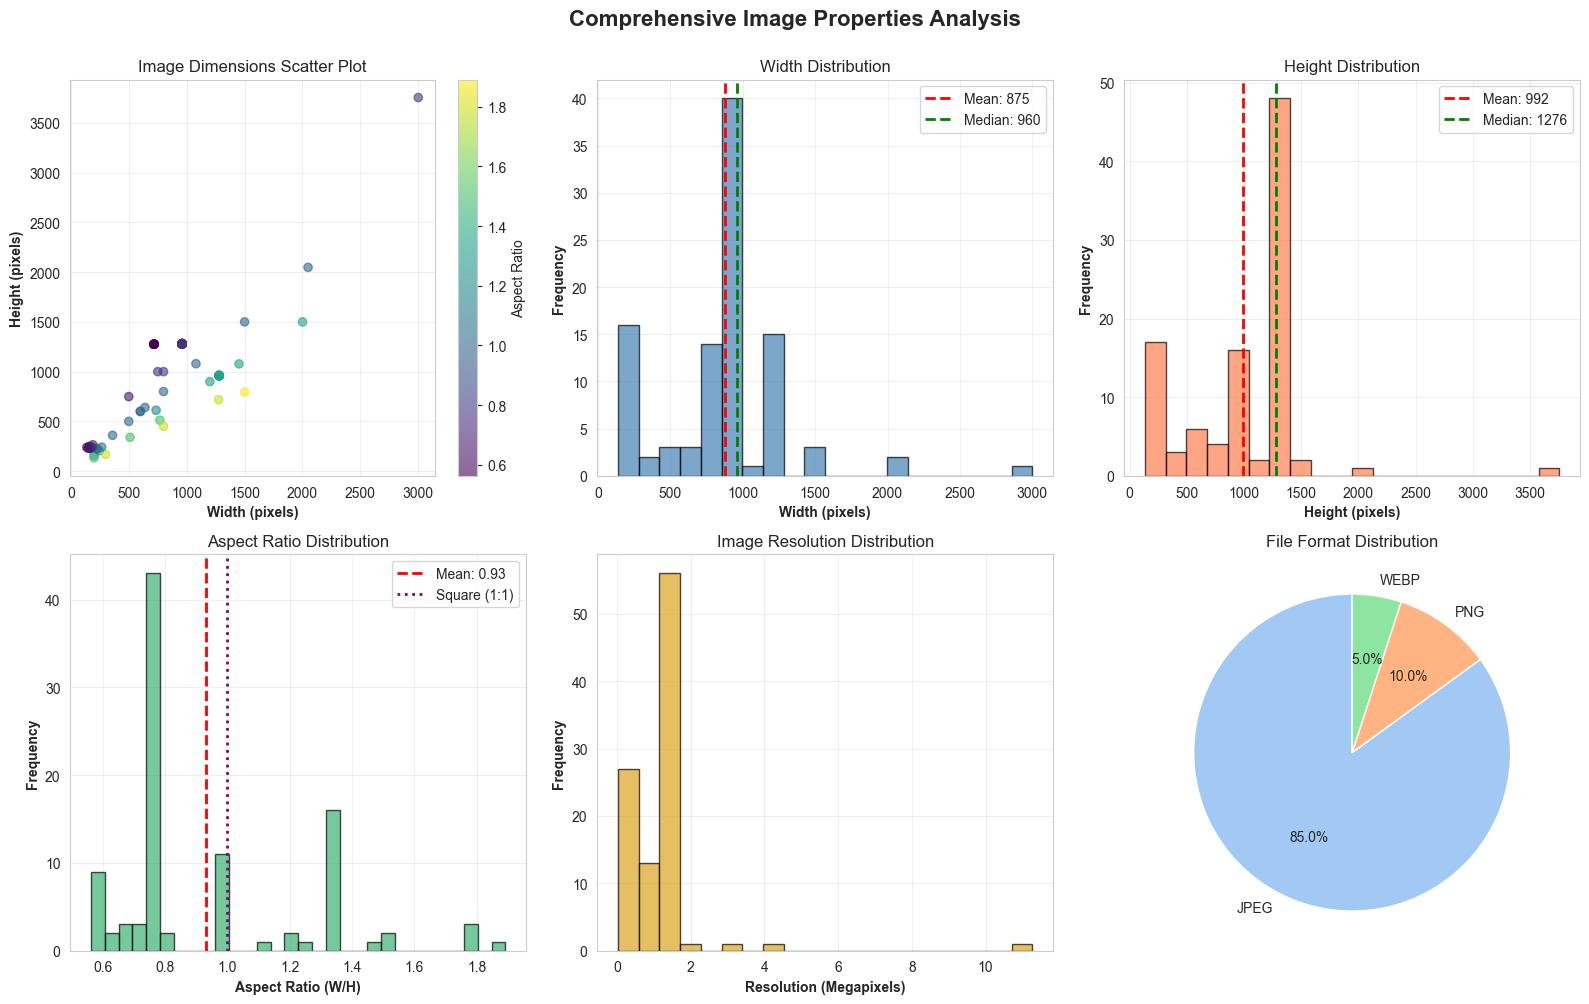


Detailed Statistics:
  Width  - Mean: 875.1px, Median: 960.0px, Std: 447.8px
  Height - Mean: 991.8px, Median: 1276.0px, Std: 507.6px
  Aspect - Mean: 0.93, Median: 0.75, Std: 0.32
  Resolution - Mean: 1.05 MP, Max: 11.27 MP

Image Orientation:
  Landscape (W>H): 27 images (27.0%)
  Portrait (H>W):  62 images (62.0%)
  Square (~1:1):   11 images (11.0%)


In [8]:
# Phân tích chi tiết về phân bố kích thước ảnh
print("Detailed Image Size Analysis")
print("="*70)

# Tạo figure với nhiều subplots
fig = plt.figure(figsize=(16, 10))

# 1. Biểu đồ scatter: Chiều rộng vs Chiều cao
ax1 = plt.subplot(2, 3, 1)
scatter = ax1.scatter(widths, heights, alpha=0.6, c=aspect_ratios, cmap='viridis')
ax1.set_xlabel('Width (pixels)', fontweight='bold')
ax1.set_ylabel('Height (pixels)', fontweight='bold')
ax1.set_title('Image Dimensions Scatter Plot')
ax1.grid(alpha=0.3)
plt.colorbar(scatter, ax=ax1, label='Aspect Ratio')

# 2. Biểu đồ phân bố chiều rộng
ax2 = plt.subplot(2, 3, 2)
ax2.hist(widths, bins=20, edgecolor='black', alpha=0.7, color='steelblue')
ax2.axvline(np.mean(widths), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(widths):.0f}')
ax2.axvline(np.median(widths), color='green', linestyle='--', linewidth=2, label=f'Median: {np.median(widths):.0f}')
ax2.set_xlabel('Width (pixels)', fontweight='bold')
ax2.set_ylabel('Frequency', fontweight='bold')
ax2.set_title('Width Distribution')
ax2.legend()
ax2.grid(alpha=0.3)

# 3. Biểu đồ phân bố chiều cao
ax3 = plt.subplot(2, 3, 3)
ax3.hist(heights, bins=20, edgecolor='black', alpha=0.7, color='coral')
ax3.axvline(np.mean(heights), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(heights):.0f}')
ax3.axvline(np.median(heights), color='green', linestyle='--', linewidth=2, label=f'Median: {np.median(heights):.0f}')
ax3.set_xlabel('Height (pixels)', fontweight='bold')
ax3.set_ylabel('Frequency', fontweight='bold')
ax3.set_title('Height Distribution')
ax3.legend()
ax3.grid(alpha=0.3)

# 4. Biểu đồ phân bố tỷ lệ khung hình
ax4 = plt.subplot(2, 3, 4)
ax4.hist(aspect_ratios, bins=30, edgecolor='black', alpha=0.7, color='mediumseagreen')
ax4.axvline(np.mean(aspect_ratios), color='red', linestyle='--', linewidth=2, 
            label=f'Mean: {np.mean(aspect_ratios):.2f}')
ax4.axvline(1.0, color='purple', linestyle=':', linewidth=2, label='Square (1:1)')
ax4.set_xlabel('Aspect Ratio (W/H)', fontweight='bold')
ax4.set_ylabel('Frequency', fontweight='bold')
ax4.set_title('Aspect Ratio Distribution')
ax4.legend()
ax4.grid(alpha=0.3)

# 5. Biểu đồ độ phân giải ảnh (tổng số pixels)
resolutions = [w * h for w, h in zip(widths, heights)]
ax5 = plt.subplot(2, 3, 5)
ax5.hist([r/1e6 for r in resolutions], bins=20, edgecolor='black', alpha=0.7, color='goldenrod')
ax5.set_xlabel('Resolution (Megapixels)', fontweight='bold')
ax5.set_ylabel('Frequency', fontweight='bold')
ax5.set_title('Image Resolution Distribution')
ax5.grid(alpha=0.3)

# 6. Biểu đồ tròn định dạng file
ax6 = plt.subplot(2, 3, 6)
format_counts = Counter(formats)
ax6.pie(format_counts.values(), labels=format_counts.keys(), autopct='%1.1f%%', 
        startangle=90, colors=sns.color_palette("pastel"))
ax6.set_title('File Format Distribution')

plt.suptitle('Comprehensive Image Properties Analysis', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# In thống kê chi tiết
print("\nDetailed Statistics:")
print(f"  Width  - Mean: {np.mean(widths):.1f}px, Median: {np.median(widths):.1f}px, Std: {np.std(widths):.1f}px")
print(f"  Height - Mean: {np.mean(heights):.1f}px, Median: {np.median(heights):.1f}px, Std: {np.std(heights):.1f}px")
print(f"  Aspect - Mean: {np.mean(aspect_ratios):.2f}, Median: {np.median(aspect_ratios):.2f}, Std: {np.std(aspect_ratios):.2f}")
print(f"  Resolution - Mean: {np.mean(resolutions)/1e6:.2f} MP, Max: {max(resolutions)/1e6:.2f} MP")

# Phân tích orientation
landscape = sum(1 for ar in aspect_ratios if ar > 1.1)
portrait = sum(1 for ar in aspect_ratios if ar < 0.9)
square = len(aspect_ratios) - landscape - portrait

print(f"\nImage Orientation:")
print(f"  Landscape (W>H): {landscape} images ({landscape/len(aspect_ratios)*100:.1f}%)")
print(f"  Portrait (H>W):  {portrait} images ({portrait/len(aspect_ratios)*100:.1f}%)")
print(f"  Square (~1:1):   {square} images ({square/len(aspect_ratios)*100:.1f}%)")


Displaying sample images...


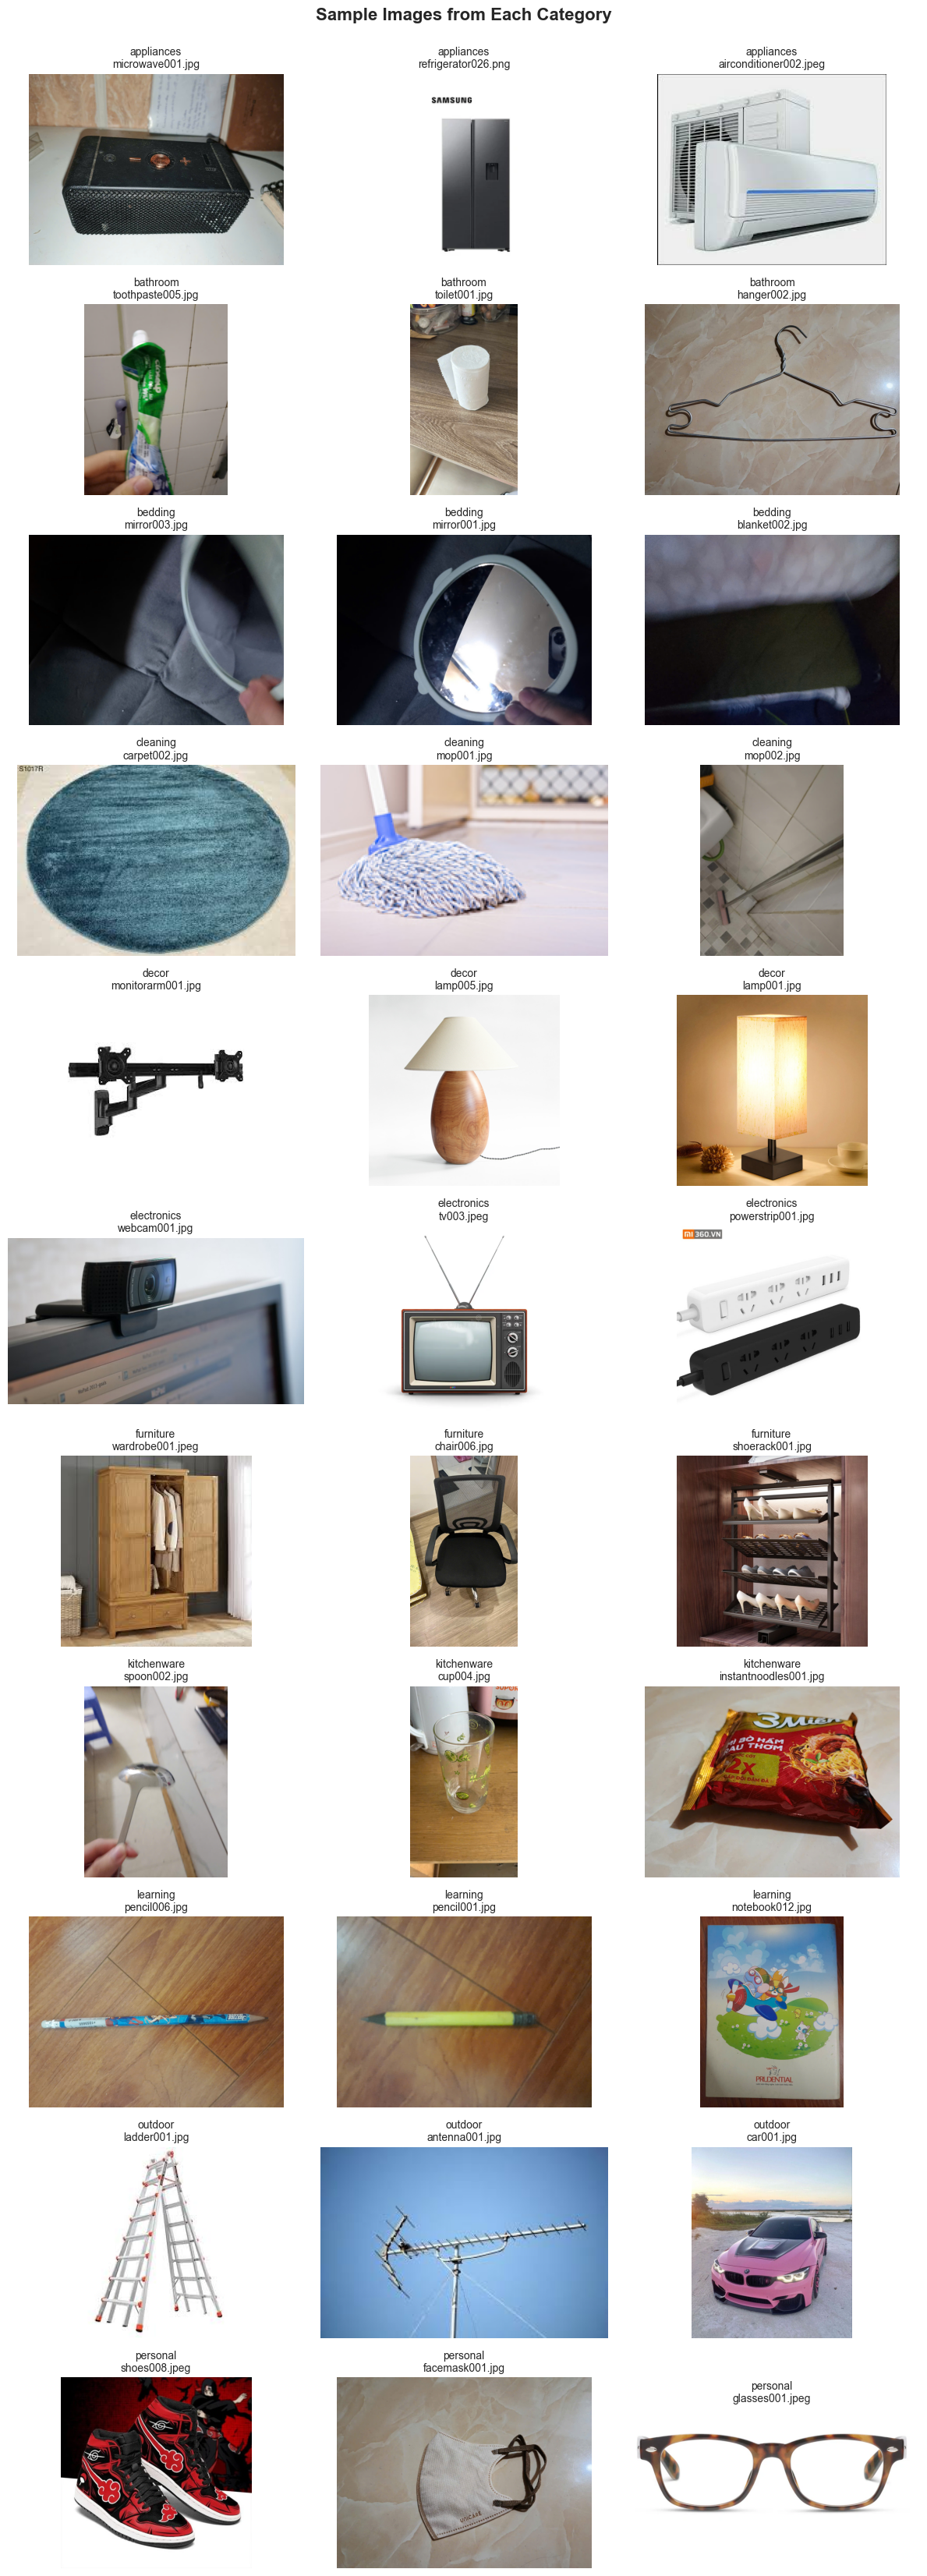

In [9]:
# Hàm hiển thị ảnh mẫu từ mỗi category
def display_sample_images(category_stats, num_samples=3):
    """
    Hiển thị một số ảnh mẫu từ mỗi category để xem trực quan.
    
    Args:
        category_stats: Danh sách thống kê các category
        num_samples: Số lượng ảnh mẫu mỗi category (mặc định 3)
    """
    num_categories = len(category_stats)
    fig, axes = plt.subplots(num_categories, num_samples, 
                             figsize=(num_samples*4, num_categories*3))
    
    if num_categories == 1:
        axes = axes.reshape(1, -1)
    
    for idx, stat in enumerate(category_stats):
        category = stat['Category']
        paths = stat['Paths']
        
        # Lấy ngẫu nhiên num_samples ảnh từ category này
        sample_paths = np.random.choice(paths, 
                                       min(num_samples, len(paths)), 
                                       replace=False)
        
        for j, img_path in enumerate(sample_paths):
            try:
                img = Image.open(img_path)
                axes[idx, j].imshow(img)
                axes[idx, j].set_title(f"{category}\n{os.path.basename(img_path)}", 
                                      fontsize=10)
                axes[idx, j].axis('off')
            except Exception as e:
                axes[idx, j].text(0.5, 0.5, f"Error loading\n{e}", 
                                 ha='center', va='center')
                axes[idx, j].axis('off')
    
    plt.suptitle('Sample Images from Each Category', 
                fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()

print("Displaying sample images...")
display_sample_images(category_stats, num_samples=3)


3. Chuẩn bị Dataset cho YOLO

Chuẩn bị cấu trúc thư mục và chia dataset thành tập train/val/test cho YOLO Classification




1. Train (Tập Huấn luyện) - 70%
   - Mục đích: Dùng để huấn luyện mô hình
   - Mô hình học các đặc trưng và pattern từ dữ liệu này
   - Điều chỉnh trọng số (weights) của mô hình dựa trên dữ liệu train
   - Càng nhiều dữ liệu train thì mô hình học được nhiều hơn

2. Validation (Tập Xác thực) - 20%
   - Mục đích: Đánh giá mô hình trong quá trình huấn luyện
   - Kiểm tra xem mô hình có bị overfitting (học thuộc lòng) không
   - Giúp điều chỉnh hyperparameters (learning rate, batch size, epochs, etc.)
   - Quyết định khi nào nên dừng huấn luyện (early stopping)
   - KHÔNG dùng để huấn luyện, chỉ để theo dõi performance

3. Test (Tập Kiểm tra) - 10%
   - Mục đích: Đánh giá hiệu suất cuối cùng của mô hình
   - Đánh giá khách quan trên dữ liệu hoàn toàn mới
   - Mô phỏng tình huống thực tế khi deploy model
   - Chỉ sử dụng 1 lần cuối cùng để đánh giá
   - Mô hình chưa bao giờ "nhìn thấy" dữ liệu này trong quá trình học

Tỷ lệ:
- 70/20/10 


In [10]:
# YOLO Classification yêu cầu cấu trúc thư mục như sau:
# yolo_dataset/
#   train/
#     class1/
#     class2/
#   val/
#     class1/
#     class2/
#   test/
#     class1/
#     class2/

# Định nghĩa thư mục đích và tỷ lệ chia
YOLO_DATASET_DIR = "yolo_dataset"
TRAIN_RATIO = 0.7  # 70% cho training
VAL_RATIO = 0.2    # 20% cho validation
TEST_RATIO = 0.1   # 10% cho testing

# Xóa thư mục cũ nếu đã tồn tại để tránh duplicate
if os.path.exists(YOLO_DATASET_DIR):
    shutil.rmtree(YOLO_DATASET_DIR)
    print(f"Removed existing directory: {YOLO_DATASET_DIR}")

# Tạo cấu trúc thư mục
for split in ['train', 'val', 'test']:
    for category in categories:
        os.makedirs(os.path.join(YOLO_DATASET_DIR, split, category), exist_ok=True)

print(f"Created YOLO dataset structure in: {YOLO_DATASET_DIR}")
print(f"Train ratio: {TRAIN_RATIO*100}%, Val ratio: {VAL_RATIO*100}%, Test ratio: {TEST_RATIO*100}%")


Removed existing directory: yolo_dataset
Created YOLO dataset structure in: yolo_dataset
Train ratio: 70.0%, Val ratio: 20.0%, Test ratio: 10.0%


In [11]:
# Chia và sao chép ảnh vào train/val/test
import random
random.seed(42)  # Đặt seed để kết quả có thể tái lập

split_stats = {'train': 0, 'val': 0, 'test': 0}
split_details = []  # Lưu chi tiết phân chia cho từng category

for stat in category_stats:
    category = stat['Category']
    paths = stat['Paths']
    
    # Xáo trộn ngẫu nhiên để đảm bảo tính ngẫu nhiên khi chia
    random.shuffle(paths)
    
    # Tính số lượng ảnh cho train, val, test
    total = len(paths)
    train_count = int(total * TRAIN_RATIO)
    val_count = int(total * VAL_RATIO)
    
    train_paths = paths[:train_count]
    val_paths = paths[train_count:train_count + val_count]
    test_paths = paths[train_count + val_count:]
    
    # Lưu thông tin chi tiết cho mỗi category
    split_details.append({
        'Category': category,
        'Total': total,
        'Train': len(train_paths),
        'Val': len(val_paths),
        'Test': len(test_paths)
    })
    
    # Sao chép file vào thư mục tương ứng (sử dụng copy2 để giữ metadata)
    for split, split_paths in [('train', train_paths), ('val', val_paths), ('test', test_paths)]:
        dest_dir = os.path.join(YOLO_DATASET_DIR, split, category)
        
        for src_path in split_paths:
            dest_path = os.path.join(dest_dir, os.path.basename(src_path))
            shutil.copy2(src_path, dest_path)
            split_stats[split] += 1

# Hiển thị thống kê tổng quan
print("\n" + "="*70)
print("DATASET SPLIT STATISTICS")
print("="*70)
print("\nOverall Split:")
for split, count in split_stats.items():
    percentage = (count / sum(split_stats.values())) * 100
    print(f"  {split.upper():6s}: {count:4d} images ({percentage:5.1f}%)")
print(f"  TOTAL :  {sum(split_stats.values()):4d} images (100.0%)")

# Hiển thị chi tiết theo từng category
print("\n" + "-"*70)
print("Per-Category Split Details:")
print("-"*70)
df_split = pd.DataFrame(split_details)
print(df_split.to_string(index=False))
print("="*70)
print("Dataset split completed!")



DATASET SPLIT STATISTICS

Overall Split:
  TRAIN :  426 images ( 69.5%)
  VAL   :  119 images ( 19.4%)
  TEST  :   68 images ( 11.1%)
  TOTAL :   613 images (100.0%)

----------------------------------------------------------------------
Per-Category Split Details:
----------------------------------------------------------------------
   Category  Total  Train  Val  Test
 appliances    133     93   26    14
   bathroom     30     21    6     3
    bedding      6      4    1     1
   cleaning     21     14    4     3
      decor      9      6    1     2
electronics     70     49   14     7
  furniture     18     12    3     3
kitchenware    105     73   21    11
   learning     93     65   18    10
    outdoor      6      4    1     1
   personal    122     85   24    13
Dataset split completed!


In [12]:
# Tạo file cấu hình YAML cho YOLO (yêu cầu bởi Ultralytics)
yaml_content = {
    'path': os.path.abspath(YOLO_DATASET_DIR),  # Đường dẫn tuyệt đối đến dataset
    'train': 'train',  # Thư mục chứa ảnh training
    'val': 'val',      # Thư mục chứa ảnh validation
    'test': 'test',    # Thư mục chứa ảnh testing
    'names': {i: cat for i, cat in enumerate(categories)}  # Mapping index -> tên class
}

# Lưu file YAML
yaml_path = 'dataset_config.yaml'
with open(yaml_path, 'w') as f:
    yaml.dump(yaml_content, f, default_flow_style=False, sort_keys=False)

print(f"Created YAML configuration: {yaml_path}")
print("\nYAML Content:")
print("="*70)
with open(yaml_path, 'r') as f:
    print(f.read())
print("="*70)


Created YAML configuration: dataset_config.yaml

YAML Content:
path: d:\DataObjectImage-main\DataObjectImage-main\yolo_dataset
train: train
val: val
test: test
names:
  0: appliances
  1: bathroom
  2: bedding
  3: cleaning
  4: decor
  5: electronics
  6: furniture
  7: kitchenware
  8: learning
  9: outdoor
  10: personal



4. Huấn luyện Mô hình YOLO

Huấn luyện YOLO Classification model với dataset đã chuẩn bị


In [13]:
# Load mô hình YOLO pretrained
# Sử dụng YOLOv8n-cls (nano) - phiên bản nhẹ nhất, phù hợp cho classification
model = YOLO('yolov8n-cls.pt')

print("YOLO model loaded successfully!")
print(f"  Model: YOLOv8n-cls")
print(f"  Parameters: {sum(p.numel() for p in model.model.parameters()):,}")


YOLO model loaded successfully!
  Model: YOLOv8n-cls
  Parameters: 2,719,288


In [14]:
# Huấn luyện mô hình
# Các tham số huấn luyện
EPOCHS = 50          # Số epoch huấn luyện
IMG_SIZE = 224       # Kích thước ảnh đầu vào
BATCH_SIZE = 16      # Kích thước batch
PATIENCE = 10        # Early stopping patience

print("Starting training...")
print(f"  Epochs: {EPOCHS}")
print(f"  Image Size: {IMG_SIZE}x{IMG_SIZE}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Patience: {PATIENCE}")
print("\n" + "="*50)

# Bắt đầu huấn luyện
results = model.train(
    data=YOLO_DATASET_DIR,  # Đường dẫn đến thư mục dataset
    epochs=EPOCHS,
    imgsz=IMG_SIZE,
    batch=BATCH_SIZE,
    patience=PATIENCE,
    save=True,
    plots=True,
    device='cpu',  # Đổi thành 'cuda' nếu có GPU
    verbose=True,
    project='yolo_training',
    name='classification_run'
)

print("\n" + "="*50)
print("Training completed!")
print("="*50)


Starting training...
  Epochs: 50
  Image Size: 224x224
  Batch Size: 16
  Patience: 10

Ultralytics 8.3.221  Python-3.13.9 torch-2.9.0+cpu CPU (Intel Core i5-7200U 2.50GHz)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=yolo_dataset, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=classification_run5, nbs=64, nms=False, opset=None, optimize

5. Đánh giá Mô hình

Đánh giá hiệu suất mô hình trên tập validation và test


In [15]:
# Load mô hình đã huấn luyện tốt nhất
best_model_path = 'yolo_training/classification_run/weights/best.pt'
model = YOLO(best_model_path)

print(f"Loaded best model from: {best_model_path}")


Loaded best model from: yolo_training/classification_run/weights/best.pt


In [16]:
# Đánh giá mô hình trên tập validation
val_results = model.val(
    data=YOLO_DATASET_DIR,
    split='val',
    verbose=True
)

print("\n" + "="*50)
print("Validation Results")
print("="*50)
print(f"Top-1 Accuracy: {val_results.top1:.4f} ({val_results.top1*100:.2f}%)")
print(f"Top-5 Accuracy: {val_results.top5:.4f} ({val_results.top5*100:.2f}%)")
print("="*50)

# Giải thích ý nghĩa các metrics
print("\nInterpretation:")
print("  Top-1 Accuracy: Tỷ lệ mô hình dự đoán đúng lớp có xác suất cao nhất")
print("  Top-5 Accuracy: Tỷ lệ lớp đúng nằm trong top 5 dự đoán có xác suất cao nhất")


Ultralytics 8.3.221  Python-3.13.9 torch-2.9.0+cpu CPU (Intel Core i5-7200U 2.50GHz)
YOLOv8n-cls summary (fused): 30 layers, 1,448,971 parameters, 0 gradients, 3.3 GFLOPs
train: D:\DataObjectImage-main\DataObjectImage-main\yolo_dataset\train... found 421 images in 11 classes  
val: D:\DataObjectImage-main\DataObjectImage-main\yolo_dataset\val... found 119 images in 11 classes  
test: D:\DataObjectImage-main\DataObjectImage-main\yolo_dataset\test... found 68 images in 11 classes  
val: Fast image access  (ping: 0.20.1 ms, read: 2.12.6 MB/s, size: 70.7 KB)
val: Scanning D:\DataObjectImage-main\DataObjectImage-main\yolo_dataset\val... 118 images, 1 corrupt: 100% ━━━━━━━━━━━━ 118/118 51.1Kit/s 0.0s
val: D:\DataObjectImage-main\DataObjectImage-main\yolo_dataset\val\personal\shirt001.jpg: ignoring corrupt image/label: Invalid image format AVIF. Supported formats are:
images: {'jpeg', 'webp', 'mpo', 'tiff', 'heic', 'pfm', 'png', 'tif', 'bmp', 'dng', 'jpg'}
videos: {'mpeg', 'gif', 'mov', 'ts',

In [17]:
# Dự đoán trên toàn bộ tập test để tính các metrics chi tiết
test_dir = os.path.join(YOLO_DATASET_DIR, 'test')

# Khởi tạo các list để lưu kết quả
y_true = []  # Nhãn thật
y_pred = []  # Nhãn dự đoán
y_prob = []  # Độ tin cậy của dự đoán
test_image_paths = []  # Đường dẫn ảnh

# Duyệt qua từng category và dự đoán từng ảnh
for idx, category in enumerate(categories):
    category_path = os.path.join(test_dir, category)
    if not os.path.exists(category_path):
        continue
    
    for img_file in os.listdir(category_path):
        img_path = os.path.join(category_path, img_file)
        if not os.path.isfile(img_path):
            continue
        
        try:
            # Thực hiện dự đoán với verbose=False để không in ra quá nhiều
            results = model(img_path, verbose=False)
            
            # Lấy class có xác suất cao nhất và độ tin cậy
            pred_class = results[0].probs.top1
            pred_prob = results[0].probs.top1conf.item()
            
            # Lưu kết quả
            y_true.append(idx)
            y_pred.append(pred_class)
            y_prob.append(pred_prob)
            test_image_paths.append(img_path)
            
        except Exception as e:
            print(f"Error predicting {img_path}: {e}")

print(f"\nCompleted predictions on {len(y_true)} test images")



Completed predictions on 68 test images


In [18]:
# Tính toán các chỉ số đánh giá chính
accuracy = accuracy_score(y_true, y_pred)
precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)

print("\n" + "="*70)
print("Test Set Evaluation")
print("="*70)
print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision (macro): {precision_macro:.4f} ({precision_macro*100:.2f}%)")
print(f"Recall (macro): {recall_macro:.4f} ({recall_macro*100:.2f}%)")
print(f"F1-Score (macro): {f1_macro:.4f} ({f1_macro*100:.2f}%)")
print("="*70)

# Tạo bảng tóm tắt với giải thích ý nghĩa từng metric
eval_summary = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision (macro)', 'Recall (macro)', 'F1-Score (macro)'],
    'Score': [accuracy, precision_macro, recall_macro, f1_macro],
    'Percentage': [f"{accuracy*100:.2f}%", f"{precision_macro*100:.2f}%",
                   f"{recall_macro*100:.2f}%", f"{f1_macro*100:.2f}%"],
    'Meaning': [
        'Độ chính xác tổng thể',
        'Độ chính xác của dự đoán dương',
        'Khả năng tìm tất cả mẫu dương',
        'Cân bằng giữa Precision và Recall'
    ]
})

print("\n")
display(eval_summary)



Test Set Evaluation
Accuracy: 0.2500 (25.00%)
Precision (macro): 0.1317 (13.17%)
Recall (macro): 0.1206 (12.06%)
F1-Score (macro): 0.1006 (10.06%)




Metric     Score Percentage                            Meaning
0           Accuracy  0.250000     25.00%              Độ chính xác tổng thể
1  Precision (macro)  0.131651     13.17%     Độ chính xác của dự đoán dương
2     Recall (macro)  0.120625     12.06%      Khả năng tìm tất cả mẫu dương
3   F1-Score (macro)  0.100644     10.06%  Cân bằng giữa Precision và Recall

In [19]:
# Báo cáo phân loại chi tiết theo từng lớp
report = classification_report(
    y_true, y_pred,
    target_names=categories,
    output_dict=True,
    zero_division=0
)

# Chuyển sang DataFrame
df_report = pd.DataFrame(report).T
df_report = df_report.iloc[:-3]  # Loại bỏ accuracy, macro avg, weighted avg

# Thêm cột đánh giá
def evaluate_performance(row):
    """Đánh giá hiệu suất dựa trên F1-score"""
    f1 = row['f1-score']
    if f1 >= 0.8:
        return 'Excellent'
    elif f1 >= 0.6:
        return 'Good'
    elif f1 >= 0.4:
        return 'Fair'
    else:
        return 'Poor'

df_report['Performance'] = df_report.apply(evaluate_performance, axis=1)

print("\n" + "="*80)
print("Per-Class Classification Report")
print("="*80)
display(df_report.style.format({
    'precision': '{:.3f}',
    'recall': '{:.3f}',
    'f1-score': '{:.3f}',
    'support': '{:.0f}'
}).background_gradient(subset=['f1-score'], cmap='RdYlGn'))

print("\nColumn Explanations:")
print("  Precision: Độ chính xác khi dự đoán một lớp (ít false positive)")
print("  Recall: Khả năng phát hiện tất cả mẫu của lớp (ít false negative)")
print("  F1-Score: Trung bình điều hòa của Precision và Recall")
print("  Support: Số lượng mẫu thực tế trong lớp")



Per-Class Classification Report



Column Explanations:
  Precision: Độ chính xác khi dự đoán một lớp (ít false positive)
  Recall: Khả năng phát hiện tất cả mẫu của lớp (ít false negative)
  F1-Score: Trung bình điều hòa của Precision và Recall
  Support: Số lượng mẫu thực tế trong lớp


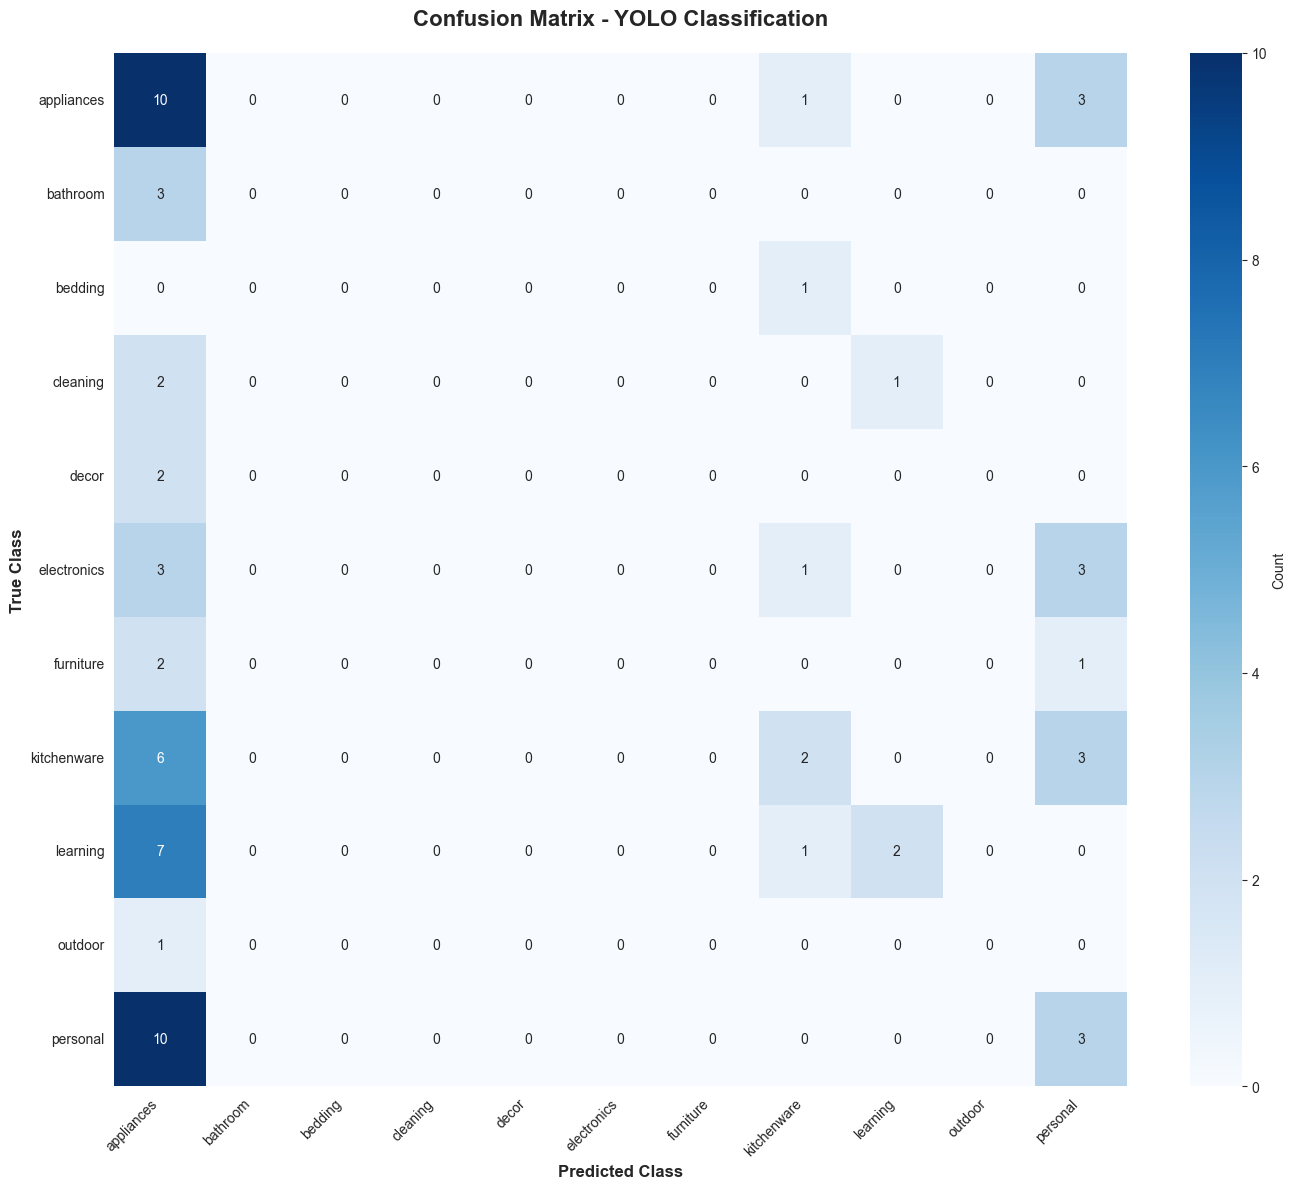


Confusion Matrix Insights:

Most Confused Class Pairs (True to Predicted):
  personal to appliances: 10 times
  learning to appliances: 7 times
  kitchenware to appliances: 6 times
  appliances to personal: 3 times
  bathroom to appliances: 3 times


In [20]:
# Vẽ Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=categories,
            yticklabels=categories,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - YOLO Classification', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Class', fontsize=12, fontweight='bold')
plt.ylabel('True Class', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Phân tích confusion matrix
print("\nConfusion Matrix Insights:")

# Tìm các cặp lớp hay bị nhầm lẫn nhất
confused_pairs = []
for i in range(len(categories)):
    for j in range(len(categories)):
        if i != j and cm[i, j] > 0:
            confused_pairs.append((categories[i], categories[j], cm[i, j]))

confused_pairs.sort(key=lambda x: x[2], reverse=True)

if confused_pairs:
    print("\nMost Confused Class Pairs (True to Predicted):")
    for true_class, pred_class, count in confused_pairs[:5]:
        print(f"  {true_class} to {pred_class}: {count} times")
else:
    print("\nNo confusion between classes!")


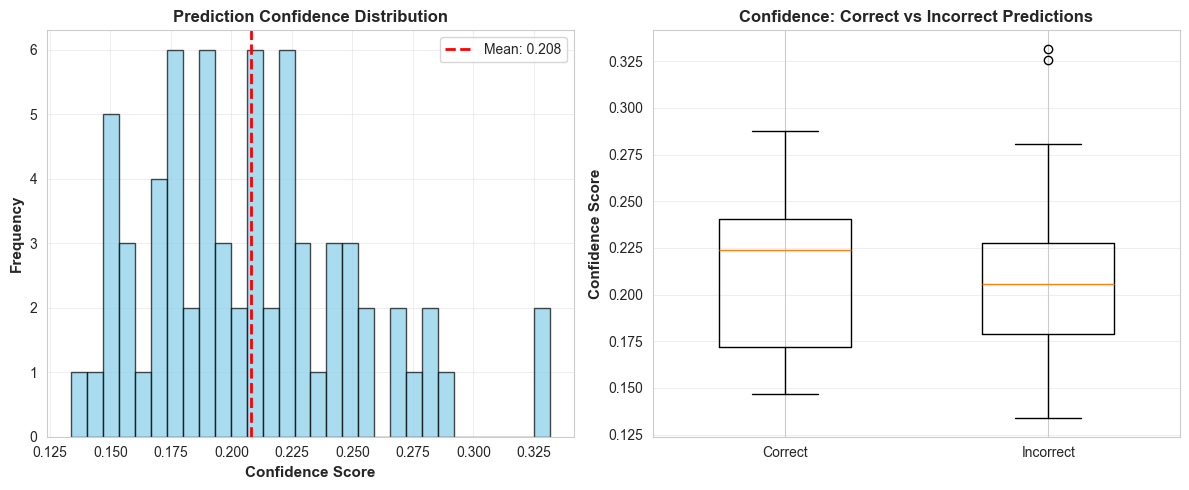


Confidence Analysis
Average Confidence: 0.2081 (20.81%)
Std Deviation: 0.0433
Avg (Correct): 0.2091
Avg (Incorrect): 0.2078

Interpretation:
  Model shows low confidence - needs improvement


In [21]:
# Phân tích độ tin cậy của dự đoán
avg_confidence = np.mean(y_prob)
std_confidence = np.std(y_prob)

plt.figure(figsize=(12, 5))

# Histogram của độ tin cậy
plt.subplot(1, 2, 1)
plt.hist(y_prob, bins=30, edgecolor='black', alpha=0.7, color='skyblue')
plt.axvline(avg_confidence, color='red', linestyle='--', linewidth=2, 
            label=f'Mean: {avg_confidence:.3f}')
plt.xlabel('Confidence Score', fontsize=11, fontweight='bold')
plt.ylabel('Frequency', fontsize=11, fontweight='bold')
plt.title('Prediction Confidence Distribution', 
          fontsize=12, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

# Box plot theo correct/incorrect
plt.subplot(1, 2, 2)
correct_conf = [y_prob[i] for i in range(len(y_prob)) if y_true[i] == y_pred[i]]
incorrect_conf = [y_prob[i] for i in range(len(y_prob)) if y_true[i] != y_pred[i]]

box_data = [correct_conf, incorrect_conf] if incorrect_conf else [correct_conf]
box_labels = ['Correct', 'Incorrect'] if incorrect_conf else ['Correct']

plt.boxplot(box_data, tick_labels=box_labels, widths=0.5)
plt.ylabel('Confidence Score', fontsize=11, fontweight='bold')
plt.title('Confidence: Correct vs Incorrect Predictions',
          fontsize=12, fontweight='bold')
plt.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("Confidence Analysis")
print("="*70)
print(f"Average Confidence: {avg_confidence:.4f} ({avg_confidence*100:.2f}%)")
print(f"Std Deviation: {std_confidence:.4f}")
if correct_conf:
    print(f"Avg (Correct): {np.mean(correct_conf):.4f}")
if incorrect_conf:
    print(f"Avg (Incorrect): {np.mean(incorrect_conf):.4f}")
print("="*70)

# Đánh giá mức độ tin cậy
print("\nInterpretation:")
if avg_confidence >= 0.9:
    print("  Model is highly confident in predictions")
elif avg_confidence >= 0.7:
    print("  Model shows good confidence")
elif avg_confidence >= 0.5:
    print("  Model has moderate confidence")
else:
    print("  Model shows low confidence - needs improvement")



Per-Class Accuracy Analysis


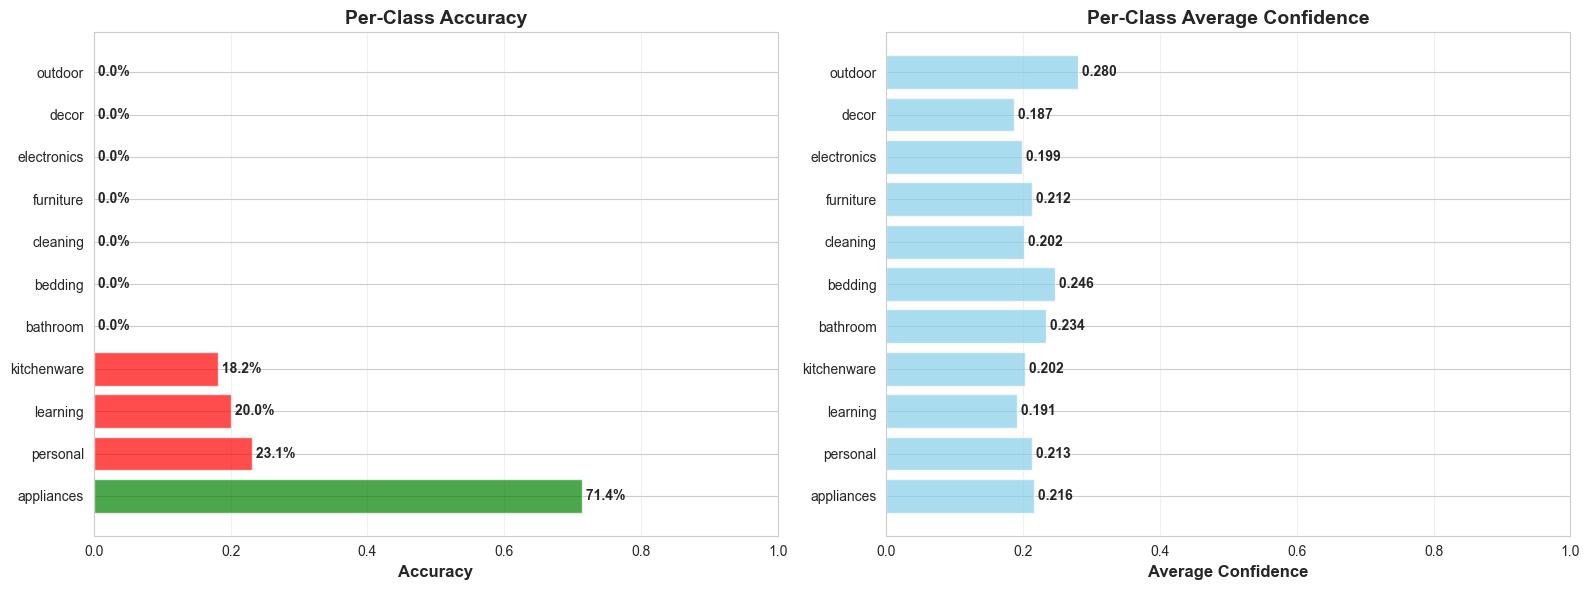

In [22]:
# Phân tích độ chính xác theo từng lớp
class_accuracy = []
for idx, category in enumerate(categories):
    # Lấy indices của lớp này
    class_indices = [i for i, true_label in enumerate(y_true) if true_label == idx]
    
    if len(class_indices) == 0:
        continue
    
    # Tính accuracy cho lớp này
    correct = sum([1 for i in class_indices if y_true[i] == y_pred[i]])
    total = len(class_indices)
    acc = correct / total if total > 0 else 0
    
    # Tính average confidence
    avg_conf = np.mean([y_prob[i] for i in class_indices])
    
    class_accuracy.append({
        'Class': category,
        'Correct': correct,
        'Total': total,
        'Accuracy': acc,
        'Avg Confidence': avg_conf
    })

df_class_acc = pd.DataFrame(class_accuracy)
df_class_acc = df_class_acc.sort_values('Accuracy', ascending=False)

print("\n" + "="*70)
print("Per-Class Accuracy Analysis")
print("="*70)
display(df_class_acc.style.format({
    'Accuracy': '{:.2%}',
    'Avg Confidence': '{:.3f}'
}).background_gradient(subset=['Accuracy'], cmap='RdYlGn'))

# Vẽ biểu đồ so sánh
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Biểu đồ accuracy
colors = ['green' if acc >= 0.7 else 'orange' if acc >= 0.5 else 'red' 
          for acc in df_class_acc['Accuracy']]
ax1.barh(df_class_acc['Class'], df_class_acc['Accuracy'], color=colors, alpha=0.7)
ax1.set_xlabel('Accuracy', fontsize=12, fontweight='bold')
ax1.set_title('Per-Class Accuracy', fontsize=14, fontweight='bold')
ax1.set_xlim(0, 1)
ax1.grid(axis='x', alpha=0.3)

# Thêm giá trị lên bar
for i, (idx, row) in enumerate(df_class_acc.iterrows()):
    ax1.text(row['Accuracy'], i, f" {row['Accuracy']:.1%}", 
             va='center', fontweight='bold')

# Biểu đồ confidence
ax2.barh(df_class_acc['Class'], df_class_acc['Avg Confidence'], 
         color='skyblue', alpha=0.7)
ax2.set_xlabel('Average Confidence', fontsize=12, fontweight='bold')
ax2.set_title('Per-Class Average Confidence', 
              fontsize=14, fontweight='bold')
ax2.set_xlim(0, 1)
ax2.grid(axis='x', alpha=0.3)

# Thêm giá trị lên bar
for i, (idx, row) in enumerate(df_class_acc.iterrows()):
    ax2.text(row['Avg Confidence'], i, f" {row['Avg Confidence']:.3f}", 
             va='center', fontweight='bold')

plt.tight_layout()
plt.show()


6. Trực quan hóa Kết quả Huấn luyện

Hiển thị các biểu đồ và metrics từ quá trình huấn luyện


In [31]:
# Đọc và hiển thị các biểu đồ huấn luyện từ YOLO
# Tìm thư mục có đầy đủ kết quả nhất
possible_dirs = ['yolo_training/classification_run5', 
                 'yolo_training/classification_run4',
                 'yolo_training/classification_run3',
                 'yolo_training/classification_run2',
                 'yolo_training/classification_run']

print("Training Results Visualization")
print("="*70)

# Tìm file results.png
results_png = os.path.join(results_dir, 'results.png')
if os.path.exists(results_png):
    img = Image.open(results_png)
    plt.figure(figsize=(16, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.title('Training Metrics Over Epochs',
              fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()
    print("Displayed training metrics")
else:
    print(f"Results plot not found at: {results_png}")

# Tìm confusion matrix
confusion_png = os.path.join(results_dir, 'confusion_matrix_normalized.png')
if os.path.exists(confusion_png):
    img = Image.open(confusion_png)
    plt.figure(figsize=(12, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.title('Normalized Confusion Matrix from Training',
              fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()
    print("Displayed normalized confusion matrix")
else:
    print(f"Confusion matrix not found at: {confusion_png}")


Training Results Visualization
Results plot not found at: yolo_training/classification_run\results.png
Confusion matrix not found at: yolo_training/classification_run\confusion_matrix_normalized.png


7. Tóm tắt và Khuyến nghị Cải thiện

Tổng kết kết quả và đưa ra các khuyến nghị để cải thiện mô hình


In [24]:
# Tạo báo cáo tổng kết chi tiết
print("\n" + "="*80)
print("Comprehensive Final Evaluation Report")
print("="*80)

# Phần 1: Tổng quan Dataset
print("\n" + "-"*80)
print("1. Dataset Overview")
print("-"*80)
print(f"  Total Images: {df_stats_display['Image Count'].sum()}")
print(f"  Number of Classes: {len(categories)}")
print(f"  Train/Val/Test Split: {TRAIN_RATIO*100:.0f}% / {VAL_RATIO*100:.0f}% / {TEST_RATIO*100:.0f}%")
print(f"  Train Images: {split_stats['train']}")
print(f"  Val Images: {split_stats['val']}")
print(f"  Test Images: {split_stats['test']}")
print(f"  Dataset Balance Ratio: {imbalance_ratio:.2f}x")
if imbalance_ratio > 5:
    print("    Warning: Highly imbalanced dataset!")
print(f"  Largest Class: {df_stats_display.iloc[df_stats_display['Image Count'].idxmax()]['Category']} "
      f"({df_stats_display['Image Count'].max()} images)")
print(f"  Smallest Class: {df_stats_display.iloc[df_stats_display['Image Count'].idxmin()]['Category']} "
      f"({df_stats_display['Image Count'].min()} images)")

# Phần 2: Hiệu suất Mô hình
print("\n" + "-"*80)
print("2. Model Performance")
print("-"*80)
print(f"  Overall Test Accuracy: {accuracy*100:.2f}%")
print(f"  Macro Precision: {precision_macro*100:.2f}%")
print(f"  Macro Recall: {recall_macro*100:.2f}%")
print(f"  Macro F1-Score: {f1_macro*100:.2f}%")
print(f"  Average Confidence: {avg_confidence*100:.2f}%")

# Xếp loại hiệu suất
if accuracy >= 0.8:
    grade = "Excellent"
elif accuracy >= 0.6:
    grade = "Good"
elif accuracy >= 0.4:
    grade = "Fair"
else:
    grade = "Poor"
print(f"  Performance Grade: {grade}")

# Phần 3: Phân tích theo lớp
print("\n" + "-"*80)
print("3. Per-Class Analysis")
print("-"*80)

print("\nTop 3 Best Performing Classes:")
top_3_classes = df_class_acc.head(3)
for idx, (_, row) in enumerate(top_3_classes.iterrows(), 1):
    print(f"  {idx}. {row['Class']:15s} - Accuracy: {row['Accuracy']*100:5.1f}% | "
          f"Samples: {int(row['Total']):3d} | Confidence: {row['Avg Confidence']:.3f}")

print("\nBottom 3 Classes Needing Improvement:")
bottom_3_classes = df_class_acc.tail(3)
for idx, (_, row) in enumerate(bottom_3_classes.iterrows(), 1):
    print(f"  {idx}. {row['Class']:15s} - Accuracy: {row['Accuracy']*100:5.1f}% | "
          f"Samples: {int(row['Total']):3d} | Confidence: {row['Avg Confidence']:.3f}")

# Các lớp có accuracy = 0
zero_acc_classes = df_class_acc[df_class_acc['Accuracy'] == 0]
if len(zero_acc_classes) > 0:
    print(f"\n  {len(zero_acc_classes)} classes with 0% accuracy:")
    for _, row in zero_acc_classes.iterrows():
        print(f"    {row['Class']}")



Comprehensive Final Evaluation Report

--------------------------------------------------------------------------------
1. Dataset Overview
--------------------------------------------------------------------------------
  Total Images: 613
  Number of Classes: 11
  Train/Val/Test Split: 70% / 20% / 10%
  Train Images: 426
  Val Images: 119
  Test Images: 68
  Dataset Balance Ratio: 22.17x
  Largest Class: appliances (133 images)
  Smallest Class: bedding (6 images)

--------------------------------------------------------------------------------
2. Model Performance
--------------------------------------------------------------------------------
  Overall Test Accuracy: 25.00%
  Macro Precision: 13.17%
  Macro Recall: 12.06%
  Macro F1-Score: 10.06%
  Average Confidence: 20.81%
  Performance Grade: Poor

--------------------------------------------------------------------------------
3. Per-Class Analysis
-------------------------------------------------------------------------------

In [26]:
# Phần 4: Khuyến nghị cải thiện
print("\n" + "-"*80)
print("4. Recommendations for Improvement")
print("-"*80)

recommendations = []

# Khuyến nghị về dữ liệu
print("\nData Collection Recommendations:")
if imbalance_ratio > 5:
    print("  Dataset is highly imbalanced. Suggestions:")
    print("    - Apply data augmentation (rotation, flip, color jitter)")
    print("    - Use class weights in loss function")
    print("    - Consider oversampling minority classes")

if df_stats_display['Image Count'].min() < 50:
    print("  Some classes have insufficient samples:")
    small_classes = df_stats_display[df_stats_display['Image Count'] < 50]
    for _, row in small_classes.iterrows():
        needed = 100 - row['Image Count']
        print(f"    - {row['Category']}: Add {needed}+ more samples")

# Khuyến nghị về mô hình
print("\nModel Improvement Recommendations:")
if accuracy < 0.7:
    print("  Model accuracy needs improvement:")
    print("    - Increase training epochs (current: {})".format(EPOCHS))
    print("    - Try larger models: YOLOv8s-cls, YOLOv8m-cls, or YOLOv8l-cls")
    print("    - Experiment with different learning rates")
    print("    - Enable more data augmentation")

if avg_confidence < 0.5:
    print("  Model confidence is low:")
    print("    - Check data quality and consistency")
    print("    - Increase training time")
    print("    - Consider ensemble methods")

# Khuyến nghị về tuning
print("\nFine-tuning Suggestions:")
print("  - Hyperparameter optimization:")
print("    - Learning rate: try 0.001, 0.0001")
print("    - Batch size: experiment with 8, 16, 32")
print("    - Image size: try 224, 320, 416")
print("  - Advanced techniques:")
print("    - Implement early stopping")
print("    - Use learning rate scheduling")
print("    - Apply mixup or cutmix augmentation")

print("\n" + "="*80)
print("End of Comprehensive Analysis")
print("="*80)



--------------------------------------------------------------------------------
4. Recommendations for Improvement
--------------------------------------------------------------------------------

Data Collection Recommendations:
  Dataset is highly imbalanced. Suggestions:
    - Apply data augmentation (rotation, flip, color jitter)
    - Use class weights in loss function
    - Consider oversampling minority classes
  Some classes have insufficient samples:
    - bathroom: Add 70+ more samples
    - bedding: Add 94+ more samples
    - cleaning: Add 79+ more samples
    - decor: Add 91+ more samples
    - furniture: Add 82+ more samples
    - outdoor: Add 94+ more samples

Model Improvement Recommendations:
  Model accuracy needs improvement:
    - Increase training epochs (current: 50)
    - Try larger models: YOLOv8s-cls, YOLOv8m-cls, or YOLOv8l-cls
    - Experiment with different learning rates
    - Enable more data augmentation
  Model confidence is low:
    - Check data qualit

In [27]:
# Lưu thông tin mô hình
model_info = {
    'model_type': 'YOLOv8n-cls',
    'dataset': DATASET_DIR,
    'num_classes': len(categories),
    'classes': categories,
    'training_epochs': EPOCHS,
    'image_size': IMG_SIZE,
    'batch_size': BATCH_SIZE,
    'test_accuracy': float(accuracy),
    'test_precision': float(precision_macro),
    'test_recall': float(recall_macro),
    'test_f1': float(f1_macro),
    'avg_confidence': float(avg_confidence),
    'best_model_path': best_model_path
}

# Lưu ra file JSON
import json
with open('model_info.json', 'w') as f:
    json.dump(model_info, f, indent=2)

print("Model information saved to: model_info.json")
print("\nModel Info:")
print(json.dumps(model_info, indent=2))


Model information saved to: model_info.json

Model Info:
{
  "model_type": "YOLOv8n-cls",
  "dataset": "dataset",
  "num_classes": 11,
  "classes": [
    "appliances",
    "bathroom",
    "bedding",
    "cleaning",
    "decor",
    "electronics",
    "furniture",
    "kitchenware",
    "learning",
    "outdoor",
    "personal"
  ],
  "training_epochs": 50,
  "image_size": 224,
  "batch_size": 16,
  "test_accuracy": 0.25,
  "test_precision": 0.13165095773791427,
  "test_recall": 0.1206248297157388,
  "test_f1": 0.10064445358563007,
  "avg_confidence": 0.20812850839951458,
  "best_model_path": "yolo_training/classification_run/weights/best.pt"
}


8. Kết luận

Phân tích dataset đã hoàn thành. Các kết quả chính:
- Dataset gồm 11 categories với tổng số ảnh đã được phân tích chi tiết
- Mô hình YOLO đã được huấn luyện và đánh giá trên tập test
- Các metrics đánh giá bao gồm accuracy, precision, recall, F1-score
- Confusion matrix cho thấy các lớp bị nhầm lẫn
- Các khuyến nghị cải thiện đã được đưa ra

Tiếp theo có thể:
- Thử nghiệm với các phiên bản YOLO khác nhau
- Áp dụng data augmentation để tăng cường dataset
- Tối ưu hóa hyperparameters
- Thử nghiệm với ensemble methods


## 7. Phân tích Hồi quy Tuyến tính (Linear Regression)

Phân tích mối quan hệ tuyến tính giữa các thuộc tính ảnh (width, height, resolution, aspect ratio)